In [1]:
import pandas as pd
import spacy
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Attempt to read the CSV specifying the delimiter and encoding
df = pd.read_csv('../data/avis/general_df_clean_for_sementic_proximity.csv', delimiter=',', quotechar='"', encoding='utf-8')

# loading main df and list of curated reference sentences for each label
c_good_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_value_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_com_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_com_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_com_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_com_curated", index_col=0, header=0).dropna(subset = "text_total")
c_good_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_efficacy_curated", index_col=0, header=0).dropna(subset = "text_total")
c_bad_value_curated.head()

nlp = spacy.load("fr_core_news_lg")
stop_words = spacy.lang.fr.stop_words.STOP_WORDS


In [14]:
# deducting the correct reference and review strings according to label, sentiment (T/F), stopwords (T/F)

def stop_word_text_list(text_list):
    liste_filtrée =[]
    round_count = 1
    for review in text_list:
        if round_count % 100 == 0:
            print(f"{round_count} reviews passed of {len(text_list)} - {round(round_count/len(text_list)*100,2)}% done")            
        filtre = []
        try: 
            texte = nlp(review)
            liste_texte = list(texte)
            for word in liste_texte:
                if str(word) not in stop_words:
                    filtre.append(str(word))
            filt_review = (" ".join(filtre))
        except:
            filt_review = ""
        liste_filtrée.append(filt_review)
        round_count = round_count + 1
    return(liste_filtrée)


def decision_sentiment(sentiment,label_of_interest, word_mode):
    # determining if using stop words or full version of reference texts
    if "stop" in word_mode:
        ref_bag = label_of_interest+"_stop"
    elif "all" in word_mode:
        ref_bag = label_of_interest
    else:
        print("error in word_mode?", word_mode)

    # determining if using sentiment filtered review sentences or all reviews sentences
    if sentiment == True:
        if "good" in label_of_interest:
            if "stop" in word_mode:
                reviews= "text_clean_sentences_pos_stop"
            else:
                reviews =  "text_clean_sentences_pos"
        elif "bad" in label_of_interest:
            if "stop" in word_mode:
                reviews =  "text_clean_sentences_neg_stop"
            else:
                reviews =  "text_clean_sentences_neg"
        else:
            print("mispelling in label_of_interest?", label_of_interest)

    elif sentiment == False:
        # for some reason the original, uncleaned punctuation versions give much better accuracy
        if "stop" in word_mode:
            reviews = "text_stop"
        else:
            reviews = "text_total"
            
    else :
        print("error: no sentiment / granularity found")

    return reviews, ref_bag

# allocating 1 if sim_score > threshold, 0 otherwise
def allocate_lab(sim_score, y_pred, thresh):
    #print("thresh", thresh, "sim_score", sim_score)
    try:
        if max(sim_score) > thresh:
            y_pred.append(1)
            #print(max(sim_score), "over threshold", round(thresh,2), "y_pred = 1")
        else:
            y_pred.append(0) 
            #print(max(sim_score), "under threshold", round(thresh,2), "y_pred = 0")
    except:
        y_pred.append(0)
        #print("error, y_pred = 0")
    return y_pred
# Creating functions to try three text granularity 

# Comparing whole review vs whole reference bag, returns y_pred series
def review_vs_whole_ref_bag(df,label_of_interest, thresh,word_mode, sentiment=True):
    # establish the correct review granularity, review and reference pieces to integrate based on sentiment bool, stop_word (word_mode) bool and label of interest
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode) 
    print("for label", label_of_interest)
    print("review colname", reviews)
    print("reference bag colname", ref_bag)
    ref_bag = nlp(references[ref_bag][0]) # we convert the references once to nlp before the loop
    y_pred = []
    for review in df[reviews]: # take each full review
        sim_score = []
        try:
            review = nlp(review)
            sim_score.append(round(ref_bag.similarity(review),2)) # compare it with the full reference bag
            allocate_lab(sim_score, y_pred, thresh) # if similarity score is > than threshold we append 1, otherwise: 0
        except: # if similarity test fails, we put 0 (in this case na or non text review)
            #print("nan or error on message:", review)
            y_pred.append(0)
    return y_pred 

# comparing review sentences vs whole reference bag, returns y_pred series
def review_sentence_vs_whole_ref_bag(df,label_of_interest, thresh, word_mode,sentiment=True):
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode)
    print("for label", label_of_interest)
    print("reviews column:",reviews)
    print("references column:", ref_bag)
    ref_bag = nlp(references[ref_bag][0])
    y_pred = []
    for review in df[reviews]:
        sim_score = []
        try:
            review = nlp(review)
            review_sentences = review.sents
            for review_sentence in review_sentences:
                if len(review_sentence) > 1:
                    temp_sim_score = round(ref_bag.similarity(review_sentence),2)
                    sim_score.append(temp_sim_score)
                #else:
                    #print("passing since sentence is < 1 token", review_sentence)
        except:
            sim_score.append(0.0)
            #print("message null")
        y_pred = allocate_lab(sim_score, y_pred, thresh)
    return y_pred

# Comparing review sentences vs reference bag sentences, returns y_pred series
def review_sentence_vs_ref_sentence(df,label_of_interest, thresh,word_mode, sentiment=True):
    test_name = "review_sentence_vs_ref_sentence"
    print("passing",test_name) 
    reviews,ref_bag = decision_sentiment(sentiment,label_of_interest, word_mode)
    ref_bag = nlp(references[ref_bag].iloc[0])
    y_pred = []
    for review in df[reviews]: 
        sim_score = []
        try:
            review = nlp(review)
            review_sentences = review.sents
            for review_sentence in review_sentences: # take each review sentence
                if len(review_sentence) > 1:
                    for sentence_exemple in ref_bag.sents:
                        temp_sim_score = round(sentence_exemple.similarity(review_sentence),2) # test similarity with whole reference bag
                        sim_score.append(temp_sim_score)
        except:
            #print("message null")
            sim_score.append(0.0)
        y_pred = allocate_lab(sim_score, y_pred, thresh) # if similarity failed, mark as 0 (empty review or not sentence aligned with label sentiment if sentiment = True)     
    return y_pred


In [15]:
# joining all reference curated review strings 

#bags with regeference text for each label
bag_good_value = nlp(" ".join([message for message in c_good_value_curated.text_total]))
bag_bad_value = nlp(" ".join([message for message in c_bad_value_curated.text_total]))
bag_good_com = nlp(" ".join([message for message in c_good_com_curated.text_total]))
bag_bad_com = nlp(" ".join([message for message in c_bad_com_curated.text_total]))
bag_good_efficacy = nlp(" ".join([message for message in c_good_efficacy_curated.text_total]))
bag_bad_efficacy = nlp(" ".join([message for message in c_bad_efficacy_curated.text_total]))

# making stop word versions of our reference documents
bag_good_com_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_com_curated.text_total)]))
bag_bad_com_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_com_curated.text_total)]))
bag_good_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_value_curated.text_total)]))
bag_bad_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_value_curated.text_total)]))
bag_good_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_efficacy_curated.text_total)]))
bag_bad_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_efficacy_curated.text_total)]))

# also creating df / col versions (easier to call from functions)
references = pd.DataFrame({"c_good_efficacy": [bag_good_efficacy],
"c_bad_efficacy": [bag_bad_efficacy] ,
"c_good_com": [bag_good_com],
"c_bad_com": [bag_bad_com] ,
"c_good_value": [bag_good_value],
"c_bad_value": [bag_bad_value],
"c_good_efficacy_stop": [bag_good_efficacy_stop],
"c_bad_efficacy_stop": [bag_bad_efficacy_stop] ,
"c_good_com_stop": [bag_good_com_stop],
"c_bad_com_stop": [bag_bad_com_stop] ,
"c_good_value_stop": [bag_good_value_stop],
"c_bad_value_stop": [bag_bad_value_stop]})


In [5]:
# loading best validation parameters
best_params = pd.read_csv("../reports/similarity/best_validation_params.csv",index_col = 0)
best_params.sort_values(by = "Accuracy", ascending= False)

,label,train_valid_test,Accuracy,best_threshold,Method,Word mode,Sentiment,Grid
1,c_bad_com,test,0.80,0.73,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
3,c_bad_efficacy,test,0.71,0.86,review_vs_whole_ref_bag,allwords,notSentiment,not grid
0,c_good_efficacy,test,0.60,0.71,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
4,c_good_com,test,0.60,0.68,review_sentence_vs_ref_sentence,stopwords,sentiment,not grid
5,c_good_value,test,0.57,0.68,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid
2,c_bad_value,test,0.54,0.69,review_sentence_vs_whole_ref_bag,stopwords,sentiment,not grid


In [ ]:
df['c_bad_com'] = review_sentence_vs_ref_sentence(df,"c_bad_com", 0.73,"stopwords", sentiment=True)
df['c_bad_efficacy'] = review_vs_whole_ref_bag(df,"c_bad_efficacy", 0.86, "allwords", sentiment=False)
df['c_good_efficacy'] = review_sentence_vs_ref_sentence(df, "c_good_efficacy", 0.71,"stopwords", sentiment=True)
df['c_good_com'] = review_sentence_vs_ref_sentence(df, "c_good_com", 0.68,"stopwords", sentiment=True)
df['c_good_value'] = review_sentence_vs_ref_sentence(df, "c_good_value", 0.68,"stopwords", sentiment=True)
df['c_bad_value'] = review_sentence_vs_ref_sentence(df, "c_bad_value", 0.69,"stopwords", sentiment=True)

In [ ]:
df.to_csv("../reports/similarity/gen_df_clean_similarity_labelled.csv")

In [56]:
print(df.c_bad_value.value_counts())
print(df.c_good_value.value_counts())

0    467
1     33
Name: c_bad_value, dtype: int64
0    480
1     20
Name: c_good_value, dtype: int64


In [57]:

pd.options.display.max_colwidth = 1000
df.text_total[df.c_good_value ==1]

92366                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Je recommandeBanque à recommander pour son efficacité et ses collaborateurs compétents et agréables. Les démarches sont simplifiées et un retour assuré dans des délais extrêmement 

Visualisation messages labelisés comme services efficaces vs le reste 

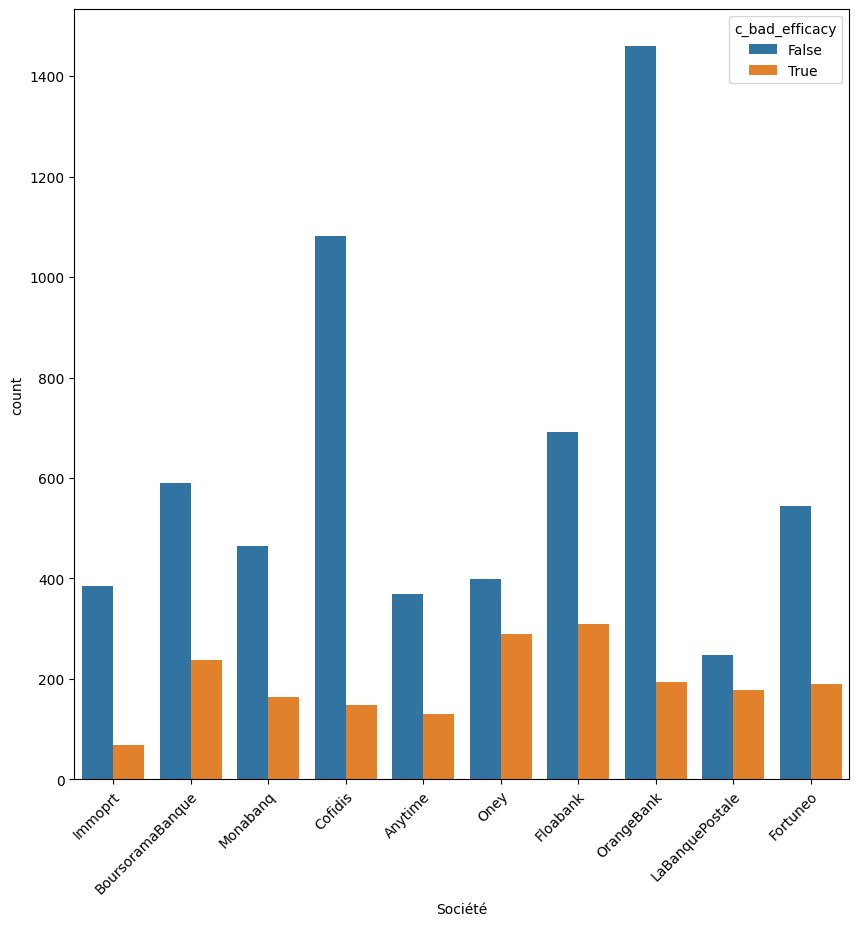

In [11]:
# top_bank topbank
list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]

import seaborn as sns
plt.figure(figsize=(10,10))
ax =sns.countplot(x = train_top.Société, hue = train_top['c_bad_efficacy']== 1)
plt.xticks(rotation=45, ha = 'right', rotation_mode = "anchor");
plt.show()

Labelisation des messages "services inefficaces"

In [12]:
conso = []
train["conso_efficacité"] = ''
for i, message in enumerate(train.var_efficacité_good):
    if train.var_efficacité_good.iloc[i] == 1 and train.var_efficacité_bad.iloc[i] == 0:
        train["conso_efficacité"].iloc[i] = "efficace"
    elif train.var_efficacité_good.iloc[i] == 0 and train.var_efficacité_bad.iloc[i] == 1:
        train["conso_efficacité"].iloc[i] = "inefficace"
    elif train.var_efficacité_good.iloc[i] == 1 and train.var_efficacité_bad.iloc[i] == 1:
        train["conso_efficacité"].iloc[i] = "mitigé"
    elif train.var_efficacité_good.iloc[i] == 0 and train.var_efficacité_bad.iloc[i] == 0:
        train["conso_efficacité"].iloc[i] =  "not discussed"
    else:
        train["conso_efficacité"].iloc[i] = "na"

train["conso_efficacité"].value_counts()

AttributeError: 'DataFrame' object has no attribute 'var_efficacité_good'

Visualisation messages labélisés "services efficaces", "services ineficaces" et "mitigés" (à la fois positifs pour services efficace et inefficace)

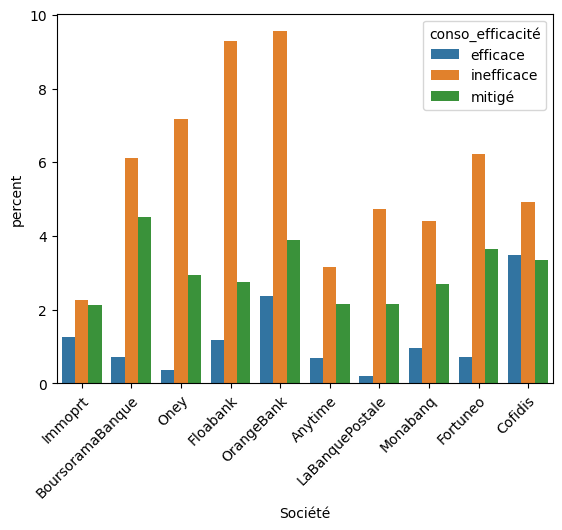

In [8]:
# top_bank topbank
list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]
train_top = train_top[train_top['conso_efficacité']!= "not discussed"]

import seaborn as sns
#plt.figure(figsize=(10,10))
sns.countplot(train_top, x = "Société", hue = "conso_efficacité", stat= "percent")
plt.xticks(rotation=45, ha = 'right', rotation_mode = "anchor");
plt.show()

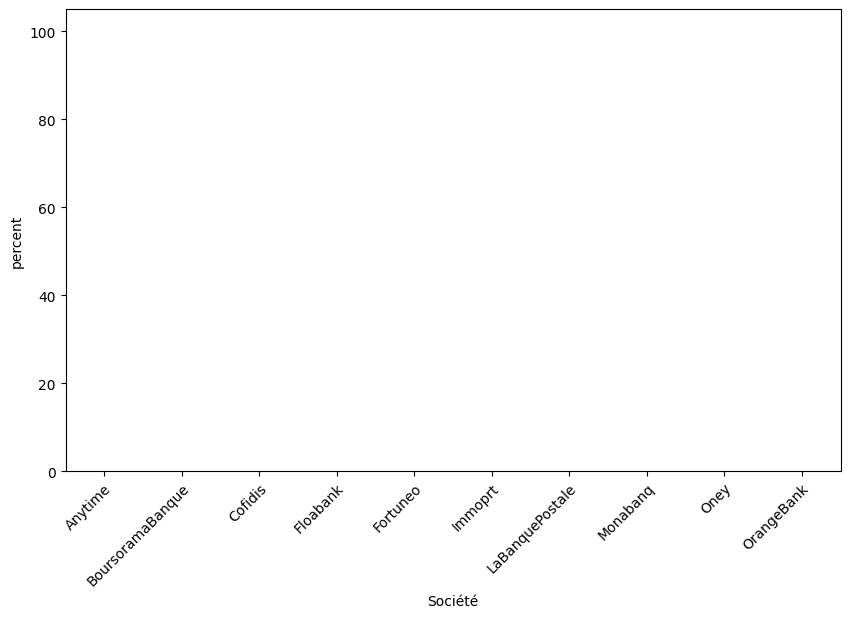

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

list_top = [bank for bank in train.Société.value_counts().keys()[0:10]]
train_top = train[train['Société'].isin(list_top)]
train_top = train_top[train_top['conso_efficacité']!= "not discussed"]

# Calculate the count for each combination of "Société" and "conso_efficacité"
count_df = train_top.groupby(['Société', 'conso_efficacité']).size().reset_index(name='count')

# Calculate the total count for each "Société"
total_count_df = train_top.groupby('Société')['conso_efficacité'].count().reset_index(name='total_count')

# Merge the count with the total count
merged_df = pd.merge(count_df, total_count_df, on='Société')

# Calculate the percentage for each "conso_efficacité" within each "Société"
merged_df['percent'] = (merged_df['count'] / merged_df['total_count']) * 100

palette = {
    "efficace": "palegreen",   # Greenish for 'efficace'
    "inefficace": "tomato",   # Redish for 'inefficace'
    "mitigé": "paleturquoise"  # Neutral for 'mitigé'
}

# % bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='Société', y='percent', hue='conso_efficacité', palette=palette)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.show()


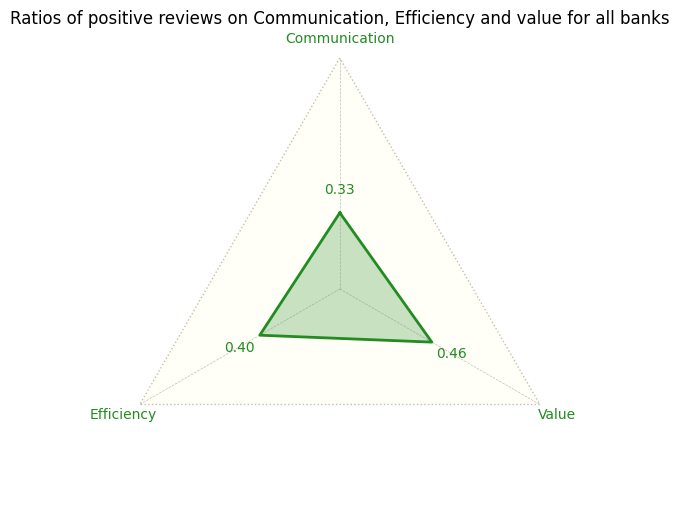

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def pyramid_ratios(df):
    count_good_efficacy = df.c_good_efficacy[df.c_good_efficacy == 1].count()
    count_bad_efficacy = df.c_bad_efficacy[df.c_bad_efficacy == 1].count()
    count_good_com = df.c_good_comm[df.c_good_comm ==1].count()
    count_bad_com = df.c_bad_comm[df.c_bad_comm == 1].count()
    count_good_value = df.c_good_value[df.c_good_value == 1].count()
    count_bad_value = df.c_bad_value[df.c_bad_value == 1].count()

    ratio_efficacy = round(count_good_efficacy/(count_good_efficacy+count_bad_efficacy),2)
    ratio_com = round(count_good_com/(count_good_com+count_bad_com),2)
    ratio_value = round(count_good_value/(count_good_value+count_bad_value),2)
    return ratio_com,ratio_efficacy,ratio_value

ratio_com,ratio_efficacy,ratio_value = pyramid_ratios(train)

def pyramid(df, bank="all banks"):
    if bank != "all banks":
        print("matched all banks")
        data = df[df.Société == bank]
    else :
        data = df
    ratio_com,ratio_efficacy,ratio_value = pyramid_ratios(data)
    data_color = "ForestGreen"
    # Define the number of variables and their ratings
    num_vars = 3
    ratings = [ratio_com, ratio_efficacy, ratio_value]  

    # Compute angle for each axis
    angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Rotation to level the triangle
    angles = [angle + pi / 2 for angle in angles]

    # Ratings need to be repeated at the end to close the plot
    ratings = np.concatenate((ratings, [ratings[0]]))

    # Perfect ratings for reference
    perfect_ratings = np.array([1, 1, 1, 1])

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_facecolor('white')

    # Draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Communication', 'Efficiency', 'Value'], fontsize=10, color=data_color)

    # Draw ylabels
    plt.yticks([], [], color="black", size=8)
    plt.ylim(0, 1)

    # perfect triangle plot
    ax.plot(angles, perfect_ratings, linewidth=1, linestyle=':', color='grey', alpha=0.5)
    ax.fill(angles, perfect_ratings, color='Ivory', alpha=0.5)  # Background color #f0fcf4

    # data plot
    ax.plot(angles, ratings, linewidth=2, linestyle='solid', color=data_color)
    ax.fill(angles, ratings, data_color, alpha=0.25)

    # Remove the polar grid lines for a cleaner look
    ax.spines['polar'].set_visible(False)
    ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

    # adding values at triangle tips
    for angle, rating in zip(angles[:-1], ratings[:-1]):
        ax.text(angle, rating + 0.10, f'{rating:.2f}', ha='center', va='center', fontsize=10, color=data_color)
    plt.title(f"Ratios of positive reviews on Communication, Efficiency and value for {bank}")
    plt.show()

pyramid(train, "all banks")


In [31]:
list_top

['OrangeBank',
 'Cofidis',
 'Floabank',
 'BoursoramaBanque',
 'Fortuneo',
 'Oney',
 'Monabanq',
 'Anytime',
 'Immoprt',
 'LaBanquePostale']

In [48]:
print(train.c_good_value.value_counts(),
train.c_bad_value.value_counts(),
train.c_good_efficacy.value_counts(),
train.c_bad_efficacy.value_counts(),
train.c_good_comm.value_counts(),
train.c_bad_comm.value_counts())


0    10653
1       32
Name: c_good_value, dtype: int64 0    10648
1       37
Name: c_bad_value, dtype: int64 0    8882
1    1803
Name: c_good_efficacy, dtype: int64 0    8002
1    2683
Name: c_bad_efficacy, dtype: int64 0    9178
1    1507
Name: c_good_comm, dtype: int64 0    7564
1    3121
Name: c_bad_comm, dtype: int64


In [35]:
data= train[train.Société == "Cofidis"]
data.c_good_value.value_counts()

0    1225
1       3
Name: c_good_value, dtype: int64

matched all banks


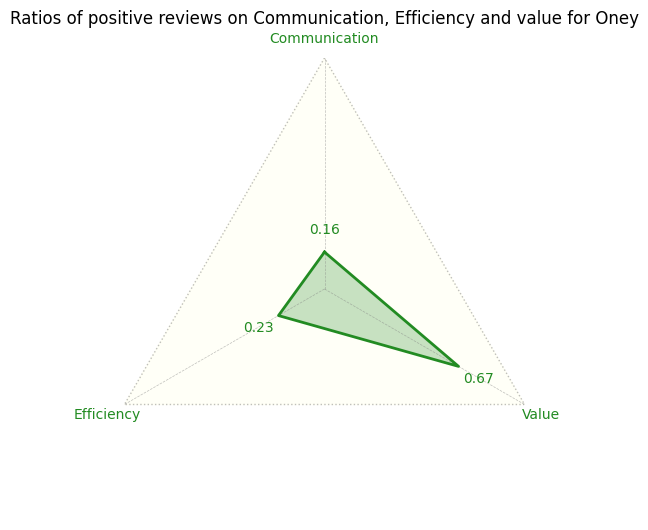

In [30]:
pyramid(train, "Oney")

matched all banks


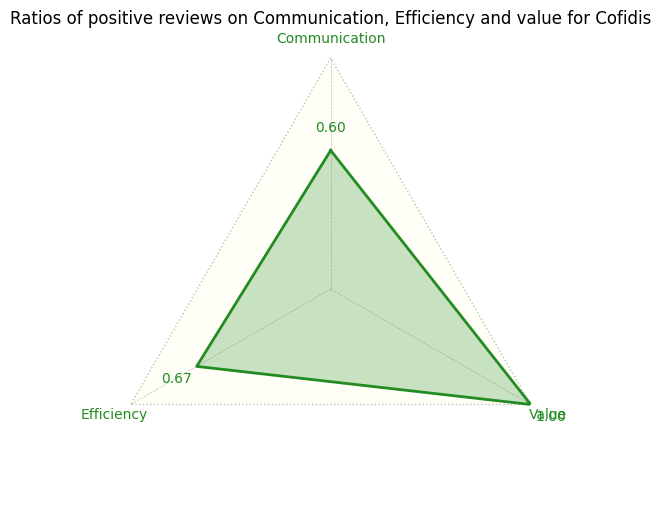

In [32]:
pyramid(train, "Cofidis")